# Pulsar detection 

## Introduction
### Background information

A pulsar is a celestial body which emits precise amounts of electromagnetic radiation. It is highly sought after by astrophysicists as it is the only place where they can observe matter indirectly at nuclear density. The 8 columns of data are divided to two categories: Integrated profile and DM_SNR curve. Integrated profile is the integration and colmination of individual observation and DM_SNR  is Signal-to-noise ratio. 

### Question?


Can we build an accurate classifier to distinguish pulsars from other celestial bodies solely based on data gathered from integrated profiles?



### Dataset

The utilized dataset is [HTRU2 Data Set](https://archive.ics.uci.edu/ml/datasets/HTRU2) collected by Dr Robert Lyon, University of Manchester. 

## Preliminary exploratory data analysis:

In [1]:
# loading dependencies
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**1. Showing that the data can be read and tidying the data**

In [25]:
# loading the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
destFile <- "pulsarData.zip"
download.file(url, destFile)
df <- read_csv(unzip("pulsarData.zip", "HTRU_2.csv"), col_names = FALSE)


# adding the column names
colnames(pulsarData) <- c("MeanIntegratedprofile", # X1
                           "SdIntegratedProfile",   # X2
                           "ExcessKurtosisIntegratedProfile", # X3
                           "SkewnessIntegratedProfile", #X4
                           "MeanDM_SNRcurve", # X5
                           "SdDM_SNRcurve",  #X6
                           "ExcessKurtosisDM_SNRcurve", #X7
                           "SkewnessDM_SNRcurve", #X8
                           "Class") #X9

# factoring the class 
pulsarData = mutate(pulsarData, Class = as.factor(Class))

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**2. Dividing the data into training data and validating data**

In [3]:
pulsarSplit <- initial_split(pulsarData, prop = 0.75, strata = Class)
pulsarTrain <- training(pulsarSplit)
pulsarTesting <- testing(pulsarSplit)

**3. Summarize the data in at least one table**

Chosen features: Mean, SD, ExcessKurtosis and Skrewness of Integrated profile (Column 1, 2, 3, 4 respectively)

In [4]:
pulsarTrain %>% group_by(Class) %>% summarize(Count = n(), 
                                              IQRMeanIntegratedprofile = IQR(MeanIntegratedprofile), 
                                              MedianSdIntegratedprofile = mad(SdIntegratedProfile), 
                                              MeanExcessKurtosisIntegratedProfile = mean(ExcessKurtosisIntegratedProfile),
                                              SkewnessIntegratedProfile = mean(SkewnessIntegratedProfile))

Class,Count,IQRMeanIntegratedprofile,MedianSdIntegratedprofile,MeanExcessKurtosisIntegratedProfile,SkewnessIntegratedProfile
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,12198,22.95117,5.932752,0.2120536,0.3830901
1,1225,48.42969,8.689180,3.0999647,15.4052067


**4. visualize the data**

By Observe all relationships between each varialibles, we focus on Mean, SD, ExcessKurtosis and Skrewness of Integrated profile.

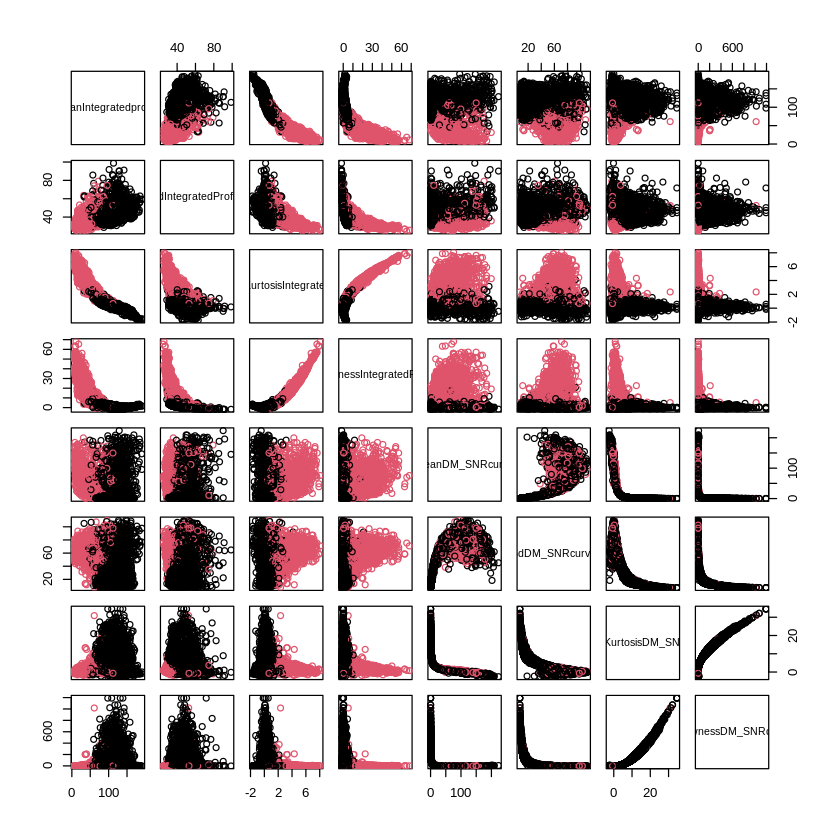

In [5]:
plot(pulsarTrain[1:8], col= pulsarTrain$Class)

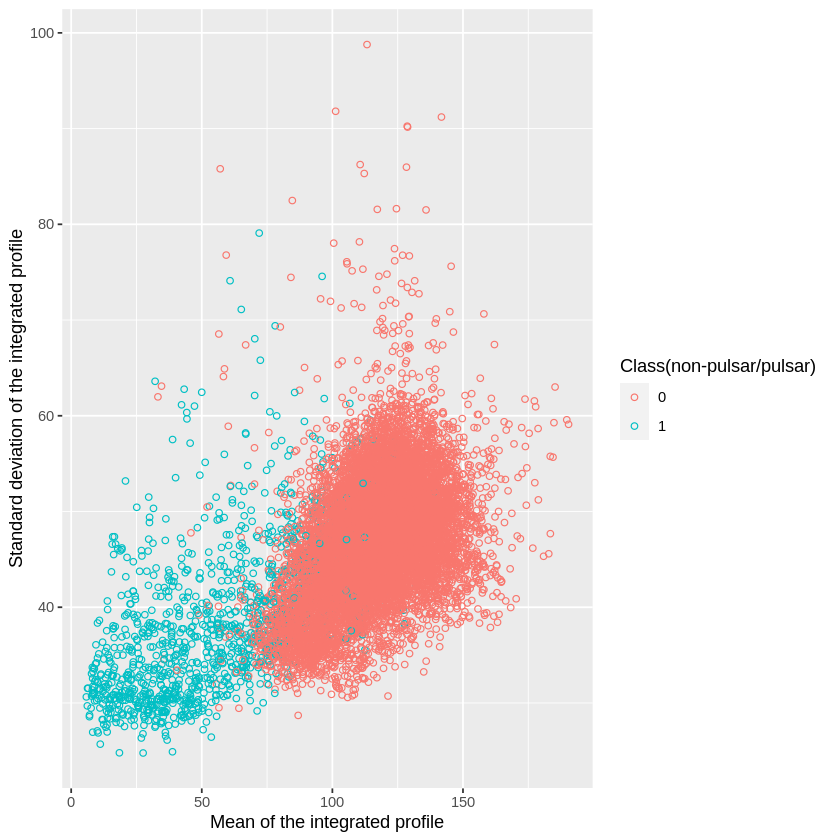

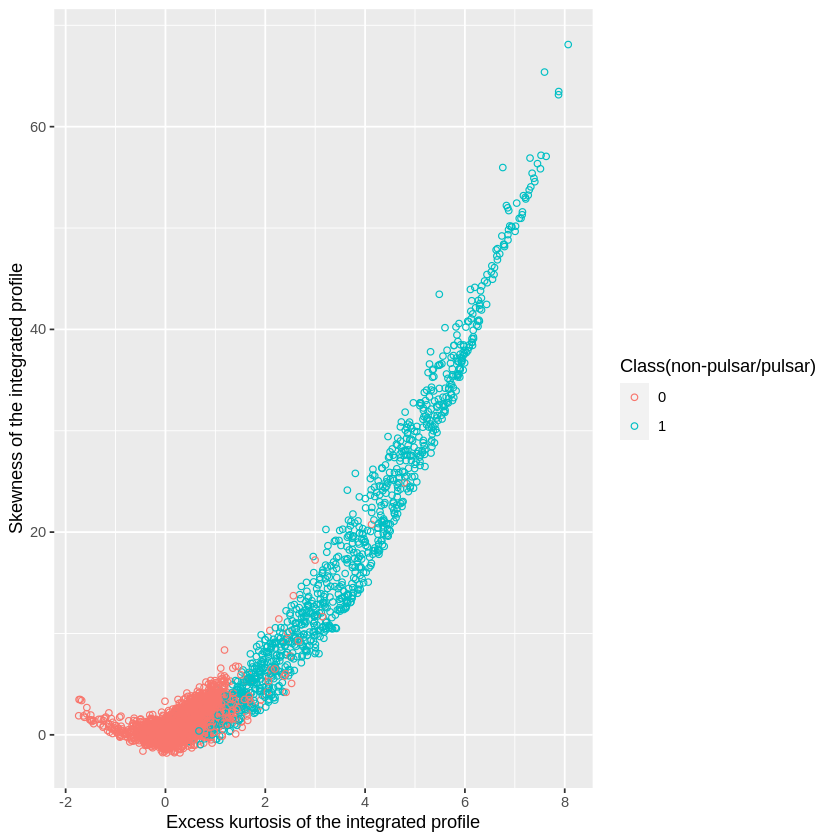

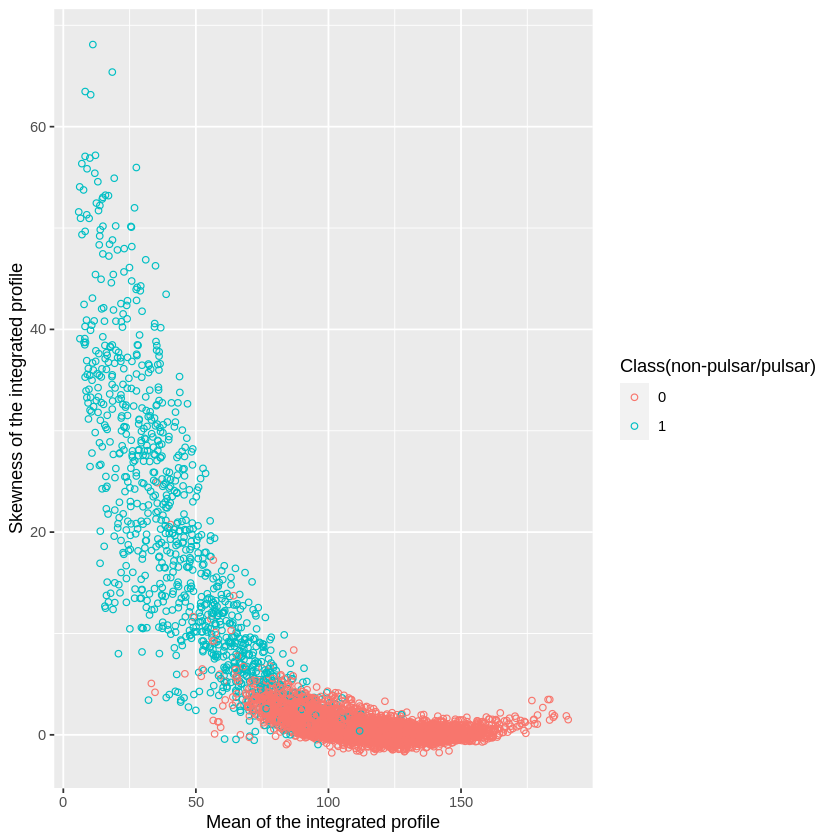

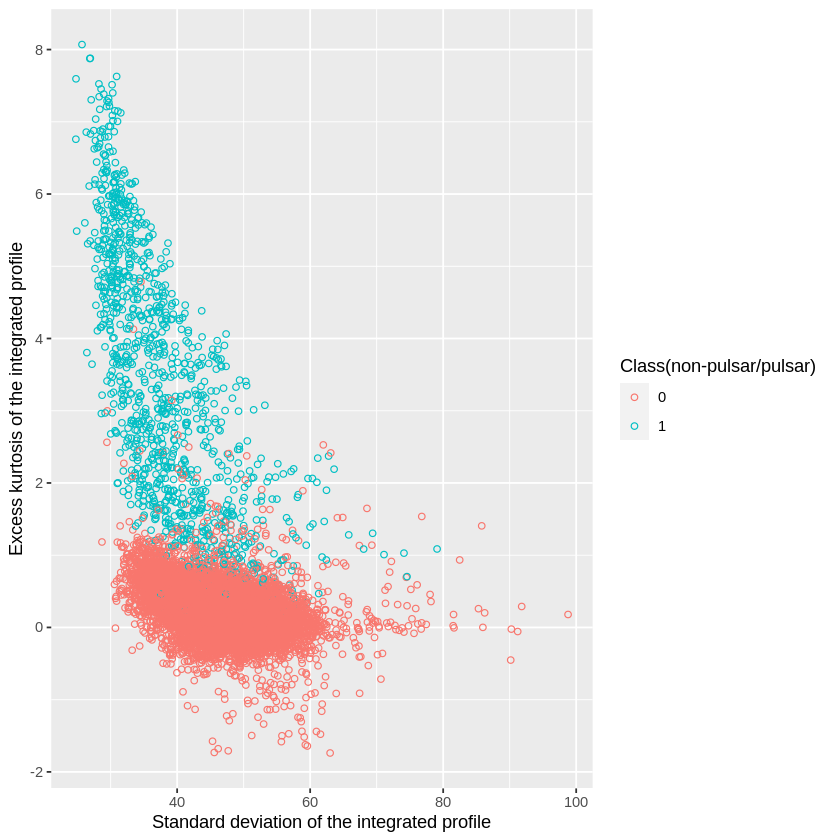

In [6]:
p1 <- pulsarTrain |>
        ggplot(aes( x = MeanIntegratedprofile, y = SdIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Mean of the integrated profile", y = "Standard deviation of the integrated profile", col = "Class(non-pulsar/pulsar)")
p1

p2 <- pulsarTrain |>
        ggplot(aes( x = ExcessKurtosisIntegratedProfile, y = SkewnessIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Excess kurtosis of the integrated profile", y = "Skewness of the integrated profile", col = "Class(non-pulsar/pulsar)")
p2

p3 <- pulsarTrain |>
        ggplot(aes( x = MeanIntegratedprofile, y = SkewnessIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Mean of the integrated profile", y = "Skewness of the integrated profile", col = "Class(non-pulsar/pulsar)")
p3

p3 <- pulsarTrain |>
        ggplot(aes( x =SdIntegratedProfile, y = ExcessKurtosisIntegratedProfile, col = Class)) +
        geom_point(shape = 1) +
        labs(x = "Standard deviation of the integrated profile", y = "Excess kurtosis of the integrated profile", col = "Class(non-pulsar/pulsar)")
p3

## Methods
### Explain how you will conduct either your data analysis and which variables/columns you will use
Classification will be used in to determine if radiation detected from a celestial body can be categorized as a pulsar. The data from integrated profiles will be used as features. **The columns to be used are the following: MeanIntegratedProfile, SdIntegratedProfile, ExcessKurtosisIntegratedProfile, SkewnessIntegratedProfile.**

### Describe at least one way that you will visualize the results
The result can be visualized using a bar plot showing the number of accurate and inaccurate pulsar detection by the classifier. 

## Expected outcomes and significance:
### What do you expect to find?
We expect to be able to classify incoming radiation accurately using the integrated profiles given that they are the combination of all of the individual pulses. However, the accuracy of the model will be limited as some noise will be in the integrated profiles (i.e., radiation of daily activites such as microwave and radio will be present in this database)
### What impact could such findings have?
It can further advance the field of astrophysics as the pulsars are used to study general relativity. Pulsar maps that are used for navigation and identification of position in space can gain higher accuracy. 

### What future questions could this lead to?
Knowing the locations of stars to be able for future scientists to examine this data to enhance the research of outer space exploration with more precise calculations of distance which will, in the future, lead to the upgraded technology of space travelling.